In [1]:
import json
import os
import pandas as pd
from datetime import datetime
import pickle 
from matplotlib import pyplot as plt
from collections import Counter
import numpy as np
import torch
import logging
from tqdm import tqdm
import ast

from utils.tree_utils import *
from utils.utils import *
from dataset import *
from model import *

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
import math

In [23]:
out_dir = '../data/'
data_dir = '../data/'
journalist = 'muyixiao'
batch_size = 4

In [665]:
dp = []
rel = []
journal_sort = pd.read_csv((os.path.join(out_dir, f'{journalist}/{journalist}_conv_labels.csv')))
ids = []
for item in list(journal_sort['conversation_id']):
    if item not in ids:
        ids.append(item)
id_pair = {}
id_conv = {}
for idx in ids:
    id_pair[idx], id_conv[idx] = create_conversation_list(journal_sort[journal_sort['conversation_id']==idx], idx)
id_data, uid, data, label = create_data(journal_sort, ids)

# prob = pkl.load(open(os.path.join(data_dir, f'{journalist}/{journalist}_edgeprob.pkl'), 'rb'))

with open(os.path.join(data_dir, f'{journalist}/{journalist}_global_path.txt'), "r") as f:
    for line in tqdm(f, total=get_number_of_lines(f)):
        dp.append(json.loads(line.strip()))

with open(os.path.join(data_dir, f'{journalist}/{journalist}_local_path.txt'), "r") as f:
    for line in tqdm(f, total=get_number_of_lines(f)):
        rel.append(json.loads(line.strip()))

global_input = convert_global(dp, id_data)
# local_data = convert_local(rel)
# local_mat = generate_local_mat(local_data, id_data)
# local_input = create_mat(local_mat, mat_type='concat')

100%|██████████| 2634/2634 [00:01<00:00, 1935.27it/s]


In [29]:
def load_data(data_dir, journalist, classes, batch_size, collate):
    ### Data (normalize input inter-event times, then padding to create dataloaders)
    num_classes, num_sequences = classes, 0
    seq_dataset = []
    arr = []
    dp = []
    rel = []
    
    split = [3, 16]
    val = 0
    journal_sort = pd.read_csv((os.path.join(data_dir, f'{journalist}/{journalist}_conv_labels.csv')))
    ids = []
    for item in list(journal_sort['conversation_id']):
        if item not in ids:
            ids.append(item)
    id_pair = {}
    id_conv = {}
    for idx in ids:
        id_pair[idx], id_conv[idx] = create_conversation_list(journal_sort[journal_sort['conversation_id']==idx], idx)
    id_data, uid, data, label = create_data(journal_sort, ids)
    prob = pkl.load(open(os.path.join(data_dir, f'{journalist}/{journalist}_edgeprob.pkl'), 'rb'))
    
    with open(os.path.join(data_dir, f'{journalist}/{journalist}_global_path.txt'), "r") as f:
        for line in tqdm(f, total=get_number_of_lines(f)):
            dp.append(json.loads(line.strip()))

    with open(os.path.join(data_dir, f'{journalist}/{journalist}_local_path.txt'), "r") as f:
        for line in tqdm(f, total=get_number_of_lines(f)):
            rel.append(json.loads(line.strip()))
    
    global_input = convert_global(dp, id_data)
    local_data = convert_local(rel)
    local_mat = generate_local_mat(local_data, id_data)
    local_input = create_mat(local_mat, mat_type='concat')
    logging.info(f'loaded split {journalist}...')
    # data - dict: dim_process, devtest, args, train, dev, test, index (train/dev/test given as)
    # data[split] - list dicts {'time_since_start': at, 'time_since_last_event': dt, 'type_event': mark} or
    # data[split] - dict {'arrival_times', 'delta_times', 'marks'}
    # data['dim_process'] = Number of accounts = 119,298
    # num_sequences: number of conversations of a journalist
    num_classes = classes
    num_sequences = len(set(journal_sort['conversation_id']))
    
    # id_train, id_dev, id_test = id_data[:split[0]], id_data[split[0]:split[1]], id_data[split[1]:]
    # uid_train, uid_dev, uid_test = uid[:split[0]], uid[split[0]:split[1]], uid[split[1]:]
    # X_train, X_dev, X_test = data[:split[0]], data[split[0]:split[1]], data[split[1]:]
    # prob_train, prob_dev, prob_test = prob[:split[0]], prob[split[0]:split[1]], prob[split[1]:]
    # global_train, global_dev, global_test = global_input[:split[0]], global_input[split[0]:split[1]], global_input[split[1]:]
    # local_train, local_dev, local_test = local_input[:split[0]], local_input[split[0]:split[1]], local_input[split[1]:]
    # label_train, label_dev, label_test = label[:split[0]], label[split[0]:split[1]], label[split[1]:]

    id_train, id_dev, id_test = id_data[split[0]:split[1]], id_data[:split[0]], id_data[split[1]:]
    uid_train, uid_dev, uid_test = uid[split[0]:split[1]], uid[:split[0]], uid[split[1]:]
    X_train, X_dev, X_test = data[split[0]:split[1]], data[:split[0]], data[split[1]:]
    prob_train, prob_dev, prob_test = prob[split[0]:split[1]], prob[:split[0]], prob[split[1]:]
    global_train, global_dev, global_test = global_input[split[0]:split[1]], global_input[:split[0]], global_input[split[1]:]
    local_train, local_dev, local_test = local_input[split[0]:split[1]], local_input[:split[0]], local_input[split[1]:]
    label_train, label_dev, label_test = label[split[0]:split[1]], label[:split[0]], label[split[1]:]

    d_train = TreeDataset(id_train, uid_train, X_train, prob_train, global_train, local_train, label_train)
    d_val = TreeDataset(id_dev, uid_dev, X_dev, prob_dev, global_dev, local_dev, label_dev)  
    d_test  = TreeDataset(id_test, uid_test, X_test, prob_test, global_test, local_test, label_test)   


    # for padding input sequences to maxlen of batch for running on gpu, and arranging them by length efficient
    collate = collate  
    dl_train = DataLoader(d_train, batch_size=batch_size, shuffle=False, collate_fn=collate)
    dl_val = DataLoader(d_val, batch_size=batch_size, shuffle=False, collate_fn=collate)
    dl_test = DataLoader(d_test, batch_size=batch_size, shuffle=False, collate_fn=collate)
    return dl_train, dl_val, dl_test





In [30]:
# data, labels, prob, global_path, local_path, torch.tensor(masks)
train, val, test = load_data(out_dir, journalist, 3, batch_size, collate)


100%|██████████| 16/16 [00:00<00:00, 8308.64it/s]


In [26]:
# val
with open(os.path.join(out_dir, f'{journalist}/strat_val.pkl'), 'rb') as file:
    strat_val = pickle.load(file)

with open(os.path.join(out_dir, f'{journalist}/true_labels.pkl'), 'rb') as file:
    true_labels = pickle.load(file)

with open(os.path.join(out_dir, f'{journalist}/pred_val.pkl'), 'rb') as file:
    pred_val = pickle.load(file)

with open(os.path.join(out_dir, f'{journalist}/output_val.pkl'), 'rb') as file:
    output_val = pickle.load(file)

with open(os.path.join(out_dir, f'{journalist}/predicted.pkl'), 'rb') as file:
    predicted = pickle.load(file)
# train
with open(os.path.join(out_dir, f'{journalist}/strat_tr.pkl'), 'rb') as file:
    strat_train = pickle.load(file)

with open(os.path.join(out_dir, f'{journalist}/pred_tr.pkl'), 'rb') as file:
    pred_train = pickle.load(file)
    
with open(os.path.join(out_dir, f'{journalist}/output.pkl'), 'rb') as file:
    output_train = pickle.load(file)
# test
with open(os.path.join(out_dir, f'{journalist}/strat_te.pkl'), 'rb') as file:
    strat_test = pickle.load(file)

with open(os.path.join(out_dir, f'{journalist}/pred_te.pkl'), 'rb') as file:
    pred_test = pickle.load(file)




In [32]:
labels_tr = []
strat_tr = []
uid_tr = []
output_tr = []
pred_tr = []
for i, item in enumerate(train):  # Assuming 'val' is your validation dataset
    # Forward pass
    #print(i)
    mask = item.masks.float()
    mask_bool = mask.bool()
    labels = item.labels[mask_bool]

    strat_temp = torch.Tensor(strat_train[i])
    pred_temp = torch.Tensor(pred_train[i])
    output_temp = torch.Tensor(output_train[i])

    # output_temp = torch.Tensor(output_val[i])
    # pred_temp = torch.Tensor(pred_val[i])
    # strat_temp = torch.Tensor(strat_val[i])
    
    output_tr.append(output_temp[mask_bool].tolist())
    pred_tr.append(pred_temp[mask_bool].tolist())
    uid_tr.append(item.uid[mask_bool].tolist()) 
    strat_tr.append(strat_temp[mask_bool].tolist())
    labels_tr.append(labels.tolist())


In [33]:
pred_te = []
strat_te = []
for i, item in enumerate(test):  # Assuming 'val' is your validation dataset
    # Forward pass
    #print(i)
    mask = item.masks.float()
    mask_bool = mask.bool()
    labels = item.labels[mask_bool]

    strat_temp = torch.Tensor(strat_test[i])
    pred_temp = torch.Tensor(pred_test[i])

    pred_te.append(pred_temp[mask_bool].tolist())
    strat_te.append(strat_temp[mask_bool].tolist())


## User Cluster

In [34]:
user = np.array([item for sublist in output_tr for item in sublist])
labels = np.array([item for sublist in pred_tr for item in sublist])

In [395]:
labels = []
for item in data_2d:
    if item[0] < 2 and item[1] > 0.1:
        labels.append(0)
    elif item[0] < -3 and item[1] > 0:
        labels.append(0)
    elif item[0] >4 and item[1] < 0:
        labels.append(2)
    elif item[0] >9 and item[1] < 1.8:
        labels.append(2)
    else:
        labels.append(1)

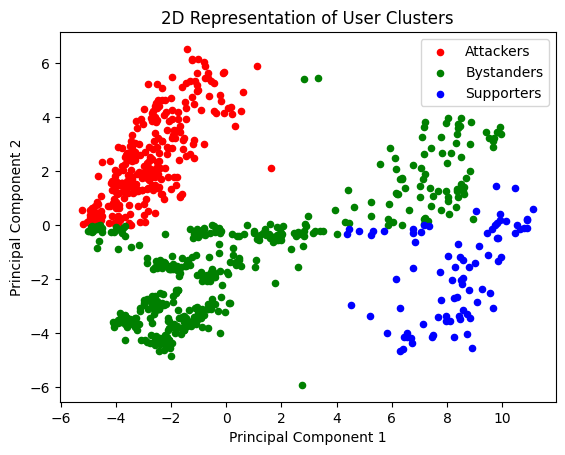

In [396]:
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Example: Replace this with your actual multi-dimensional data
data = user  # Random data with 5 dimensions


pca = PCA(n_components=2)
pca.fit(data)
data_2d = pca.transform(data)

group = labels
cdict = {0: 'Red', 1: 'Green', 2: 'Blue'}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(data_2d[:, 0][ix], data_2d[:, 1][ix], c = cdict[g], label = g, s = 20)
ax.legend()

plt.title("2D Representation of User Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(['Attackers', 'Bystanders', 'Supporters'])
plt.savefig('../result/cluster_lingling.png', bbox_inches='tight')
plt.show()

In [35]:
user_label = {}
for i in range(len(labels_tr)):
    for j in range(len(labels_tr[i])):
        if uid_tr[i][j] not in user_label.keys():
            user_label[uid_tr[i][j]] = ([labels_tr[i][j]], [strat_tr[i][j]])
        else:
            user_label[uid_tr[i][j]][0].append(labels_tr[i][j])
            user_label[uid_tr[i][j]][1].append(strat_tr[i][j])


In [36]:
np.mean([strat_tr[0][0]], axis=0)

array([0.08586945, 0.10313469, 0.05693509, 0.10864182, 0.17370731,
       0.25151843, 0.06475481, 0.15543842])

In [37]:
user_strat = {0:[], 1:[], 2:[]}
for k, v in user_label.items():
    if 0 in v[0]:
        user_strat[0].append(np.mean(v[1], axis=0))
    elif 2 in v[0]:
        user_strat[2].append(np.mean(v[1], axis=0))
    else:
        user_strat[1].append(np.mean(v[1], axis=0))

In [38]:
print(np.mean(user_strat[0], axis=0))
print(np.mean(user_strat[1], axis=0))
print(np.mean(user_strat[2], axis=0))

[0.12677151 0.11697769 0.16980086 0.12518489 0.09913733 0.13606339
 0.10633168 0.11973265]
[0.14566841 0.11490491 0.13483612 0.12687582 0.10511835 0.11471075
 0.14982386 0.10806179]
[0.12547498 0.10136525 0.12200688 0.13564198 0.12121297 0.17086338
 0.11223759 0.11119698]


In [39]:
strat_0 = []
strat_1 = []
strat_2 = []
for i in range(len(labels_tr)):
    for j, item in enumerate(labels_tr[i]):
        if item == 0:
            strat_0.append(strat_tr[i][j])
        elif item == 1:
            strat_1.append(strat_tr[i][j])
        elif item == 2:
            strat_2.append(strat_tr[i][j])

print(len(strat_0), len(strat_1), len(strat_2))

77 150 141


In [253]:
#scale = np.array([1e-1, 1, 1e2, 1e2, 1e2, 1e2, 1e2, 1e2])
scale = np.array([0.4, 5e0, 5e0, 1e1, 1e1, 1e1, 1e1, 1e1])
scale1 = np.array([1.5, 2.5, 1.5, 1.5, 2.5, 1.5, 1.5, 1.5])

In [40]:
ms_0 = (np.mean(np.array(strat_0), 0)) 
ms_1 = (np.mean(np.array(strat_1), 0)) 
ms_2 = (np.mean(np.array(strat_2), 0)) 
print(ms_0, ms_1, ms_2)

[0.12882457 0.10887161 0.19268564 0.11576389 0.10115023 0.12657945
 0.1013096  0.12481501] [0.14318181 0.10525518 0.13969871 0.13371258 0.10855815 0.11665981
 0.13547747 0.11745629] [0.13100814 0.0964545  0.14213638 0.12795892 0.1187837  0.1704576
 0.09498744 0.11821333]


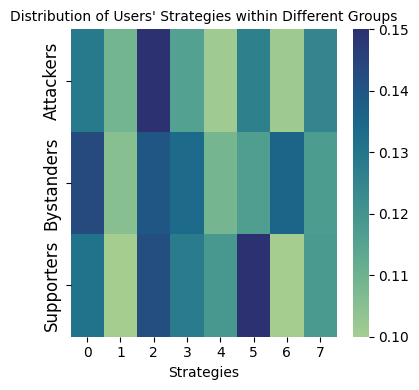

In [41]:
import seaborn as sns
data_2d = np.vstack([ms_0, ms_1, ms_2])


plt.figure(figsize=(4, 4))  # Adjust the size as needed
sns.heatmap(data_2d, cmap="crest", vmin=0.1, vmax=0.15, yticklabels=["Attackers", "Bystanders", "Supporters"])  # Choose a colormap that fits your data
# viridis, , annot=True
# Optional: Add labels, title, etc.
plt.title("Distribution of Users' Strategies within Different Groups", size=10)
plt.xlabel("Strategies", size=10)#
#plt.ylabel("Row")
plt.tick_params(axis='y', labelsize=12)

# Display the heatmap
plt.tight_layout()

# Display the heatmap
plt.savefig('../result/heatmap_muyixiao.png', bbox_inches='tight')
plt.show()

## draw tree

In [629]:
max_level = []
max_width = []
for item in global_input[84:]:
    m_level = 0
    m_width = 0
    for x in item:
        level = max(y[0] for y in x)
        width = max(y[2] for y in x)
        if level > m_level:
            m_level = level
        if width > m_width:
            m_width = width
    max_level.append(m_level)
    max_width.append(m_width)
        

In [630]:
labels = []
for item in pred_test:
    labels.extend(item)

In [631]:
frac = []
for item in labels:
    l0 = sum(x==0 for x in item) / len(item)
    l1 = sum(x==1 for x in item) / len(item)
    l2 = sum(x==2 for x in item) / len(item)
    frac.append([l0, l1, l2])

# for item in pred_te:
#     l0 = sum(x==0 for x in item) / len(item)
#     l1 = sum(x==1 for x in item) / len(item)
#     l2 = sum(x==2 for x in item) / len(item)
#     frac.append([l0, l1, l2])

In [489]:
level_tox_sort = {1: 0.071428, 2: 0.0667, 3: 0.045, 6: 0.1818, 7: 0.0325, 24: 0.2780}

In [634]:
import collections
frac0 = [item[1] for item in frac]
level_tox = {}
for i, k in enumerate(max_level):
    if k not in level_tox.keys():
        level_tox[k] = [frac0[i]]
    else:
        level_tox[k].append(frac0[i])
level_tox_sort = collections.OrderedDict(sorted(level_tox.items()))

scale = [0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 
         0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025]
x = list(level_tox_sort.keys()) 
y = [np.mean(list(level_tox_sort.values())[i]) for i in range(len(level_tox))]


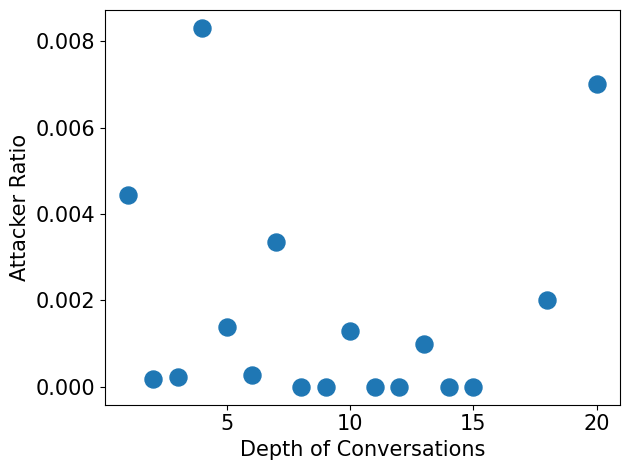

In [636]:
plt.scatter(x, y, s=150)
#plt.title("Relations Between Depth of Conversations and the Fraction of Attackers", size=20)
plt.xlabel("Depth of Conversations", size=15)#
plt.ylabel("Attacker Ratio", size=15)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

# Display the heatmap
plt.tight_layout()

# Display the heatmap
plt.savefig('../result/depth_JiayangFan.png', bbox_inches='tight')
plt.show()

In [642]:
def map_id(pair):
    map_pair = {}
    i = 0
    for item in pair:
        if item[0] not in map_pair.keys():
            map_pair[item[0]] = i
            i += 1
        if item[1] not in map_pair.keys():
            map_pair[item[1]] = i
            i += 1
    mapped_pair = [[map_pair[item[0]], map_pair[item[1]]] for item in pair]
    return mapped_pair, map_pair

In [650]:
labels = [-1, 2, 2, 1, 2, 2, 0, 1, 1, 1, -1, 0, 0, 2, 1, 1, 2, 0, 2, 0, 1, 1]
map_color = {0:'red', 1: 'green', 2: 'blue', -1: 'grey'}
mapped_color = [map_color[item] for item in labels]
pair = id_pair[1019]

node_pairs, map_pair = map_id(id_pair[1019])
node_list = [map_pair[item] for item in id_data[19]]

In [651]:
missed = []
for item in node_pairs:
    if item[0] not in node_list:
        missed.append(item[0])
    if item[1] not in node_list:
        missed.append(item[1])
print(set(missed))

{0, 10}


In [652]:
import plotly.graph_objects as go

# Example node pairs
node_pairs = node_pairs

# Function to calculate positions - this will vary greatly depending on your tree structure
positions = {0: (0, 0), 1: (-2.5, -1), 2: (-3, -2), 3: (-2, -2), 4: (-3, -3), 5: (-3.5, -4), 
             6: (-3.5, -5), 7: (-2.5, -4), 8: (-1.5, -1), 9: (-3.5, -3), 10: (-0.5, -1), 
             11: (-1, -2), 12: (0, -2), 13: (-3.5, -6), 14: (0.5, -1), 15: (-4, -3), 
             16: (-2.5, -3), 17: (0.5, -2), 18: (0.5, -3), 19: (0.5, -4), 20: (1.5, -1), 21: (2.5, -1),}


# Create edges
edge_x = []
edge_y = []
for pair in node_pairs:
    x0, y0 = positions[pair[0]]
    x1, y1 = positions[pair[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

# Create nodes
node_x = [pos[0] for pos in positions.values()]
node_y = [pos[1] for pos in positions.values()]

# Create figure
fig = go.Figure()

# Add edges as lines
fig.add_trace(go.Scatter(x=edge_x, y=edge_y, mode='lines', line=dict(width=2, color='grey')))

# Add nodes as markers
# mode='markers+text'
fig.add_trace(go.Scatter(x=node_x, y=node_y, mode='markers', text=list(positions.keys()), textposition="bottom center",
                         marker=dict(size=10, color=mapped_color, line=dict(width=2, color='DarkSlateGrey'))))

# Update layout
fig.update_layout(template="plotly_white", xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                  yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
fig.show()


In [653]:
max_dep = 0
max_i = 0
for i, item in enumerate(global_input):
    for x in item:
        if len(x) > max_dep and i <= 99 and len(x) < 10:
            max_dep = len(x)
            max_i = i
print(max_dep, max_i)
print(label[max_i])
print(ids[max_i])

9 38
[2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
774


In [654]:
labels = [-1, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 0.0, 0.0, 1.0, 
          2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
map_color = {0:'red', 1: 'green', 2: 'blue', -1: 'grey'}
mapped_color = [map_color[item] for item in labels]

node_pairs, map_pair = map_id(id_pair[774])
node_list = [map_pair[item] for item in id_data[38]]

In [655]:
missed = []
for item in node_pairs:
    if item[0] not in node_list:
        missed.append(item[0])
    if item[1] not in node_list:
        missed.append(item[1])
print(set(missed))

{0}


In [662]:
import plotly.graph_objects as go

# Example node pairs
node_pairs = node_pairs

# Function to calculate positions - this will vary greatly depending on your tree structure
positions = {0: (0, 0), 1: (0, -1), 2: (0, -2), 3: (0, -3), 4: (0, -4), 5: (-0.5, -5), 
             6: (0.5, -1), 7: (-1, -6), 8: (-1, -7), 9: (0, -6), 10: (-1, -8), 
             11: (-2, -1), 12: (-1.5, -1), 13: (-1, -1), 14: (-0.5, -1), 15: (0.5, -1), 
             16: (1, -1), 17: (1.5, -1), 18: (0.5, -5), 19: (2, -1), 20: (2.5, -1)}


# Create edges
edge_x = []
edge_y = []
for pair in node_pairs:
    x0, y0 = positions[pair[0]]
    x1, y1 = positions[pair[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

# Create nodes
node_x = [pos[0] for pos in positions.values()]
node_y = [pos[1] for pos in positions.values()]

# Create figure
fig = go.Figure()

# Add edges as lines
fig.add_trace(go.Scatter(x=edge_x, y=edge_y, mode='lines', line=dict(width=2, color='grey')))

# Add nodes as markers
# mode='markers+text'
fig.add_trace(go.Scatter(x=node_x, y=node_y, mode='markers', text=list(positions.keys()), textposition="bottom center",
                         marker=dict(size=10, color=mapped_color, line=dict(width=2, color='DarkSlateGrey'))))

# Update layout
fig.update_layout(template="plotly_white", xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                  yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
fig.show()


In [666]:
node_pairs, map_pair = map_id(id_pair[579])
node_list = [map_pair[item] for item in id_data[22]]

In [667]:
missed = []
for item in node_pairs:
    if item[0] not in node_list:
        missed.append(item[0])
    if item[1] not in node_list:
        missed.append(item[1])
print(set(missed))

{0, 64, 51, 86}


In [686]:
labels = [-1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 
          1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 
          0, 1, 1, 1, 2, 2, 1, 1, 1, 1, 
          1, 1, 1, 2, 1, 0, 1, 1, 0, 1, 
          0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
          1, -1, 1, 2, 1, 1, 1, 0, 1, 1, 
          2, 1, 0, 2, -1, 1, 1, 1, 1, 1, 
          1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 
          1, 1, 1, 1, 1, 1, -1, 1, 1, 1]
map_color = {0:'red', 1: 'green', 2: 'blue', -1: 'grey'}
mapped_color = [map_color[item] for item in labels]



In [687]:
import plotly.graph_objects as go

# Example node pairs
node_pairs = node_pairs

# Function to calculate positions - this will vary greatly depending on your tree structure
positions = {0: (0, 0), 1: (-35, -1), 2: (-34, -1), 3: (-33, -1), 4: (-32, -1), 5: (-31, -1), 6: (-30, -1), 7: (-29, -1), 8: (-28, -1), 9: (-27, -1), 
             10: (-33, -2), 11: (-27, -2), 12: (-26, -1), 13: (-30, -2), 14: (-25, -1), 15: (-24, -1), 16: (-25, -2), 17: (-23, -1), 18: (-22, -1), 19: (-21, -1), 
             20: (-23, -2), 21: (-20, -1), 22: (-19, -1), 23: (-18, -1), 24: (-17, -1), 25: (-16, -1), 26: (-15, -1), 27: (-14, -1), 28: (-13, -1), 29: (-12, -1), 
             30: (-11, -1), 31: (-33, -3), 32: (-10, -1), 33: (-9, -1), 34: (-23, -3), 35: (-8, -1), 36: (-7, -1), 37: (-6, -1), 38: (-5, -1), 39: (-21, -2), 
             40: (-4, -1), 41: (-3, -1), 42: (-2, -1), 43: (-1, -1), 44: (1, -1), 45: (-2, -2), 46: (2, -1), 47: (3, -1), 48: (4, -1), 49: (5, -1), 
             50: (6, -1), 51: (7, -1), 52: (6, -2), 53: (8, -1), 54: (9, -1), 55: (10, -1), 56: (11, -1), 57: (12, -1), 58: (13, -1), 59: (14, -1), 
             60: (15, -1), 61: (16, -1), 62: (14, -2), 63: (14, -3), 64: (17, -1), 65: (17, -2), 66: (19, -1), 67: (20, -1), 68: (21, -1), 69: (20, -2), 
             70: (21, -1), 71: (22, -1), 72: (23, -2), 73: (23, -3), 74: (23, -1), 75: (24, -1), 76: (25, -1), 77: (26, -1), 78: (27, -1), 79: (28, -1), 
             80: (29, -1), 81: (30, -1), 82: (31, -1), 83: (32, -1), 84: (33, -1), 85: (34, -1), 86: (35, -1), 87: (35, -2), 88: (36, -1), 89: (14, -4), }


# Create edges
edge_x = []
edge_y = []
for pair in node_pairs:
    x0, y0 = positions[pair[0]]
    x1, y1 = positions[pair[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

# Create nodes
node_x = [pos[0] for pos in positions.values()]
node_y = [pos[1] for pos in positions.values()]

# Create figure
fig = go.Figure()

# Add edges as lines
fig.add_trace(go.Scatter(x=edge_x, y=edge_y, mode='lines', line=dict(width=2, color='grey')))

# Add nodes as markers
# mode='markers+text'
fig.add_trace(go.Scatter(x=node_x, y=node_y, mode='markers', text=list(positions.keys()), textposition="bottom center",
                         marker=dict(size=10, color=mapped_color, line=dict(width=2, color='DarkSlateGrey'))))

# Update layout
fig.update_layout(template="plotly_white", xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                  yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
fig.show()


: 

## Strat Evaluation

In [63]:
def collate(batch):
    batch_li = [list(item) for item in batch]
    data_temp = [row[0] for row in batch_li]
    labels_temp = [torch.Tensor(row[1]) for row in batch_li]
    prob_temp = [torch.Tensor(row[2]) for row in batch_li]
    global_path_temp = [row[3] for row in batch_li]
    local_path_temp = [row[4] for row in batch_li]
    idx_temp = [torch.Tensor(row[5]) for row in batch_li]
    

    padded_data, masks = pad_sequences(data_temp, max_dim=500, pad_token=0)
    padded_labels = pad_labels(labels_temp, max_dim=500, pad_token=0)
    padded_idx = pad_labels(idx_temp, max_dim=500, pad_token=0)
    padded_prob, _ = pad_sequences(prob_temp, max_dim=500, pad_token=0)
    padded_global, _ = pad_sequences(summ(global_path_temp), max_dim=500, pad_token=0)
    padded_local = pad_matrix(local_path_temp, max_dim=500, pad_token=0)

    data= torch.tensor(padded_data).to(torch.int64)
    labels = torch.tensor(padded_labels).to(torch.int64)
    idx = torch.tensor(padded_idx).to(torch.int64)
    prob = torch.tensor(padded_prob).to(torch.float64)
    global_path = torch.tensor(np.array(padded_global)).to(torch.int64)
    #print(type(padded_data), type(padded_data[0]))
    local_path = torch.tensor(np.array(padded_local)).to(torch.int64)
    #labels = torch.nn.utils.rnn.pad_sequence(labels_temp, batch_first=True)
    #prob = torch.nn.utils.rnn.pad_sequence(prob_temp, batch_first=True)
    #global_path = torch.nn.utils.rnn.pad_sequence(global_path_temp, batch_first=True)
    #local_path = torch.nn.utils.rnn.pad_sequence(local_path_temp, batch_first=True)
    #print(masks)
    
    #out_tweet_type = torch.nn.utils.rnn.pad_sequence(out_tweet_types, batch_first=True)
    #print("start")
    return Batch(idx, data, labels, prob, global_path, local_path, torch.tensor(masks))
    
   
def load_data(data_dir, journalist, classes, batch_size, collate):
    ### Data (normalize input inter-event times, then padding to create dataloaders)
    num_classes, num_sequences = 0, 0
    seq_dataset = []
    arr = []
    dp = []
    rel = []
    
    split = [80, 84]
    val = 0
    journal_sort = pd.read_csv((os.path.join(data_dir, f'{journalist}/{journalist}_conv_labels.csv')))
    ids = []
    for item in list(journal_sort['conversation_id']):
        if item not in ids:
            ids.append(item)
    id_pair = {}
    id_conv = {}
    for idx in ids:
        id_pair[idx], id_conv[idx] = create_conversation_list(journal_sort[journal_sort['conversation_id']==idx], idx)
    id_data, data, label = create_data(journal_sort, ids)
    prob = pkl.load(open(os.path.join(data_dir, f'{journalist}/{journalist}_edgeprob.pkl'), 'rb'))
    
    with open(os.path.join(data_dir, f'{journalist}/{journalist}_global_path.txt'), "r") as f:
        for line in tqdm(f, total=get_number_of_lines(f)):
            dp.append(json.loads(line.strip()))

    with open(os.path.join(data_dir, f'{journalist}/{journalist}_local_path.txt'), "r") as f:
        for line in tqdm(f, total=get_number_of_lines(f)):
            rel.append(json.loads(line.strip()))
    
    global_input = convert_global(dp, id_data)
    local_data = convert_local(rel)
    local_mat = generate_local_mat(local_data, id_data)
    local_input = create_mat(local_mat, mat_type='concat')
    logging.info(f'loaded split {journalist}...')
    # data - dict: dim_process, devtest, args, train, dev, test, index (train/dev/test given as)
    # data[split] - list dicts {'time_since_start': at, 'time_since_last_event': dt, 'type_event': mark} or
    # data[split] - dict {'arrival_times', 'delta_times', 'marks'}
    # data['dim_process'] = Number of accounts = 119,298
    # num_sequences: number of conversations of a journalist
    num_classes = classes
    #num_sequences += len(data[split]['arrival_times'])
    num_sequences = len(set(journal_sort['conversation_id']))
    
    id_train, id_dev, id_test = id_data[:split[0]], id_data[split[0]:split[1]], id_data[split[1]:]
    X_train, X_dev, X_test = data[:split[0]], data[split[0]:split[1]], data[split[1]:]
    prob_train, prob_dev, prob_test = prob[:split[0]], prob[split[0]:split[1]], prob[split[1]:]
    global_train, global_dev, global_test = global_input[:split[0]], global_input[split[0]:split[1]], global_input[split[1]:]
    local_train, local_dev, local_test = local_input[:split[0]], local_input[split[0]:split[1]], local_input[split[1]:]
    label_train, label_dev, label_test = label[:split[0]], label[split[0]:split[1]], label[split[1]:]

    d_train = TreeDataset(id_train, X_train, prob_train, global_train, local_train, label_train)
    d_val = TreeDataset(id_dev, X_dev, prob_dev, global_dev, local_dev, label_dev)  
    d_test  = TreeDataset(id_test, X_test, prob_test, global_test, local_test, label_test)   

    # for padding input sequences to maxlen of batch for running on gpu, and arranging them by length efficient
    collate = collate  
    dl_train = torch.utils.data.DataLoader(d_train, batch_size=batch_size, shuffle=False, collate_fn=collate)
    dl_val = torch.utils.data.DataLoader(d_val, batch_size=batch_size, shuffle=False, collate_fn=collate)
    dl_test = torch.utils.data.DataLoader(d_test, batch_size=batch_size, shuffle=False, collate_fn=collate)
    return dl_train, dl_val, dl_test

train, val, test = load_data(out_dir, journalist, 3, batch_size, collate)

100%|██████████| 2634/2634 [00:00<00:00, 5477.28it/s]


In [107]:
count = 0
result = []
for i in range(len(llh)):
    a = np.array(llh[i])
    b = np.array(strat_tr[i])
    hit = np.sum(np.sum(a * b, axis=-1) >= 0.7)
    count += 1
    result.append(hit / len(llh[i]))
print(np.sum(result) / count)

0.8088396299383888


In [110]:
llh = []
for item in train:
    mask = item.masks.float()
    mask_bool = mask.bool()
    sum = item.prob.sum(dim=-1, keepdim=True)
    result = item.prob / sum
    llh.append(result[mask_bool].tolist())
likelihood = []
for i in range(len(llh)):
    a = np.array(llh[i])
    b = np.array(strat_tr[i])
    likelihood.append(np.sum(a * b, axis=-1).tolist())

In [116]:
def flatten(lst):
    """ Flatten a 2D list into a 1D list """
    return [item for sublist in lst for item in sublist]

In [122]:
np.sum(binary_predictions)

632

In [133]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Assuming `predictions` is your list/array of predicted probabilities and `true_labels` is your ground truth
predictions = likelihood
true_labels = flatten([[1] * len(likelihood[i]) for i in range(len(likelihood))])

# Convert probabilities to binary predictions (e.g., using 0.5 as a threshold)
binary_predictions = flatten([[1 if p > 0.7 else 0 for p in item] for item in predictions])

# Evaluate
accuracy = accuracy_score(true_labels, binary_predictions)
precision = precision_score(true_labels, binary_predictions)
recall = recall_score(true_labels, binary_predictions, average='weighted', zero_division='warn')
f1 = f1_score(true_labels, binary_predictions)
#roc_auc = roc_auc_score(true_labels, binary_predictions)  # Note: ROC AUC uses the probabilities, not the binary predictions

print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")


Accuracy: 0.7532777115613826, Precision: 1.0, Recall: 0.7532777115613826, F1 Score: 0.8592794017675051


/u/yian3/.conda/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



## Test

In [207]:
labels_tr = []
strat_tr = []
for i, item in enumerate(val):  # Assuming 'val' is your validation dataset
    # Forward pass
    #print(i)
    mask = item.masks.float()
    mask_bool = mask.bool()
    labels = item.labels[mask_bool]
    strat_temp = torch.Tensor(strat_val[i])
    #pred_temp = torch.Tensor(pred_test[i])
    strat_tr.append(strat_temp[mask_bool].tolist())
    #labels_tr.append(pred_temp[mask_bool].tolist())
    labels_tr.append(labels.tolist())


In [209]:
strat_0 = []
strat_1 = []
strat_2 = []
for i in range(len(labels_tr)):
    for j, item in enumerate(labels_tr[i]):
        if item == 0:
            strat_0.append(strat_tr[i][j])
        elif item == 1:
            strat_1.append(strat_tr[i][j])
        elif item == 2:
            strat_2.append(strat_tr[i][j])

print(len(strat_0), len(strat_1), len(strat_2))

150 14 7


In [210]:
ms_0 = np.mean(np.array(strat_0), 0)
ms_1 = np.mean(np.array(strat_1), 0)
ms_2 = np.mean(np.array(strat_2), 0)
print(ms_0, ms_1, ms_2)

[0.11962023 0.14346766 0.11602822 0.12275441 0.13734565 0.10130471
 0.1300965  0.12938263] [0.42894168 0.17817303 0.07215742 0.06545482 0.05932482 0.05118508
 0.07555469 0.06920846] [0.57228889 0.18950889 0.05327873 0.0403331  0.02379078 0.03050997
 0.04997504 0.04031457]


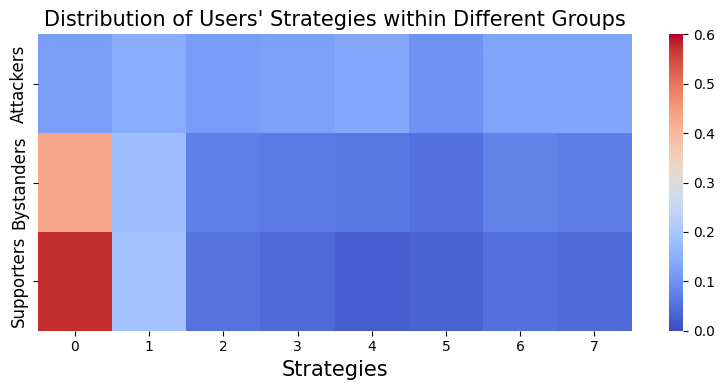

In [212]:
import seaborn as sns
data_2d = np.vstack([ms_0, ms_1, ms_2])


# Create the heatmap
plt.figure(figsize=(8, 4))  # Adjust the size as needed
sns.heatmap(data_2d, cmap="coolwarm", vmin=0, vmax=0.6, yticklabels=["Attackers", "Bystanders", "Supporters"])  # Choose a colormap that fits your data
# viridis, , annot=True
# Optional: Add labels, title, etc.
plt.title("Distribution of Users' Strategies within Different Groups", size=15)
plt.xlabel("Strategies", size=15)#
#plt.ylabel("Row")
plt.tick_params(axis='y', labelsize=12)

# Display the heatmap
plt.tight_layout()
plt.savefig('../result/heatmap_jiayangfan.png', bbox_inches='tight')
plt.show()

In [204]:
scale = [1, 1e3, 1e3, 1e3, 1e3, 1e3, 1e3, 1e3]

In [102]:
np.mean(np.array(strat_0), 0)

array([9.98642266e-01, 1.07979611e-04, 4.87784740e-04, 2.11293217e-04,
       6.35078437e-05, 2.71009480e-04, 1.48113032e-04, 6.80406926e-05])

In [121]:
np.mean(np.array(strat_1), 0)

array([9.97384846e-01, 2.43167975e-04, 8.06368771e-04, 3.80310346e-04,
       1.42341363e-04, 4.99840535e-04, 3.45563923e-04, 1.97667410e-04])

In [122]:
np.mean(np.array(strat_2), 0)

array([9.99011886e-01, 8.78300398e-05, 3.19675852e-04, 1.41030914e-04,
       4.80180978e-05, 1.94500281e-04, 1.27388699e-04, 6.96790908e-05])

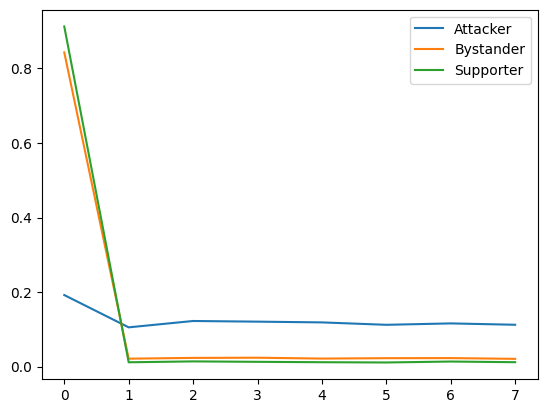

In [262]:
x = range(8)
plt.plot(x, np.mean(np.array(strat_0), 0), label='Attacker')
plt.plot(x, np.mean(np.array(strat_1), 0), label='Bystander')
plt.plot(x, np.mean(np.array(strat_2), 0), label='Supporter')
plt.legend()
plt.show()

In [ ]:
target_u = []
pred_u = []
strat_u = []

mask_u = []
true_labels = []
for i, item in enumerate(test):
    mask_u.append(item.masks)
    true_labels.append(item.labels)

for i in range(len(mask_u)):
    for j in range(len(mask_u[i])):
        mask_temp = sum(mask_u[i][j])
        pred_u.append(pred_test[i][j][:mask_temp])
        target_u.append(true_labels[i][j][:mask_temp].tolist())
        strat_t = strat_test[i][j][:mask_temp]
        strat_u.append(strat_t)

strat_0 = []
strat_1 = []
strat_2 = []

for i, item in enumerate(target_u):
    for j in range(len(item)):
        if item[j] == 0:
            strat_0.append(strat_u[i][j])
        elif item[j] == 1:
            strat_1.append(strat_u[i][j])
        else:
            strat_2.append(strat_u[i][j])